In [111]:
import xarray as xr # Basic package to deal with data arrays
import xarray_sentinel # Handles most basic SAR operations
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [ ]:
zarr_paths = sorted(glob.glob("/Users/devseed/Documents/repos/eopf-cpm/02_zarr_converted/*.zarr"))
datatrees = [xr.open_datatree(path, consolidated=True) for path in zarr_paths]
datasets = [xr.open_dataset(path, consolidated=True) for path in zarr_paths]
DATASET_NUMBER = 19

# To check for ID number of datatrees
# datatrees[1].groups
MEASUREMENTS_VH_GROUP_ID = 4
MEASUREMENTS_VV_GROUP_ID = 7
GCP_VH_GROUP_ID = 14
GCP_VV_GROUP_ID = 28
CALIBRATION_VH_GROUP_ID = 19
CALIBRATION_VV_GROUP_ID = 33

In [113]:
type(datatrees[2]) # this product S01SIWGRD_20241031T180256_0025_A322_479F_06E71E

xarray.core.datatree.DataTree

In [149]:
datatrees[2].groups[CALIBRATION_VV_GROUP_ID] # '/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VH/measurements'

'/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VV/quality/calibration'

In [115]:
datatrees[2][datatrees[2].groups[MEASUREMENTS_VH_GROUP_ID]].to_dataset()

<xarray.Dataset> Size: 870MB
Dimensions:       (azimuth_time: 16677, ground_range: 26064)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 133kB 2024-10-31T18:02:56.112...
  * ground_range  (ground_range) float64 209kB 0.0 10.0 ... 2.606e+05 2.606e+05
    line          (azimuth_time) int64 133kB ...
    pixel         (ground_range) int64 209kB ...
Data variables:
    grd           (azimuth_time, ground_range) uint16 869MB ...

In [116]:
# Create measurements list 
i = 0
measurements = []
while i < DATASET_NUMBER:
    measurements.append(datatrees[i][datatrees[i].groups[MEASUREMENTS_VH_GROUP_ID]].to_dataset())
    i = i + 1

In [159]:
# Create decimated grd list 
i = 0
grd = []
while i < DATASET_NUMBER:
    grd.append(measurements[i].grd.sel(azimuth_time=slice(None, None, 20), 
                                        ground_range=slice(None, None, 20)))
    i = i + 1

In [140]:
# set(dat.ground_range.shape for dat in measurements) # to see if all measurements have the same shape

In [160]:
# Create GCP (interpolated with decimated grd) list 
i = 0
gcp = []
while i < DATASET_NUMBER:
    gcp.append(datatrees[i][datatrees[i].groups[GCP_VH_GROUP_ID]].to_dataset())
    gcp[i] = gcp[i].interp_like(grd[i])
    i = i + 1

In [162]:
# Assinging lat and long coordinates to grd
i = 0
while i < DATASET_NUMBER:
    grd[i] = grd[i].assign_coords({"latitude": gcp[i].latitude, 
                                   "longitude": gcp[i].longitude})
    i = i + 1

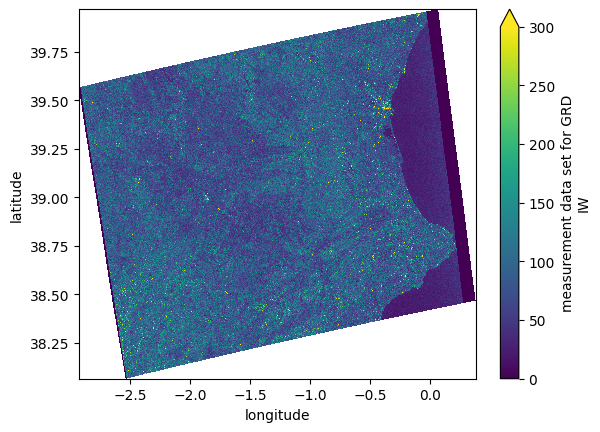

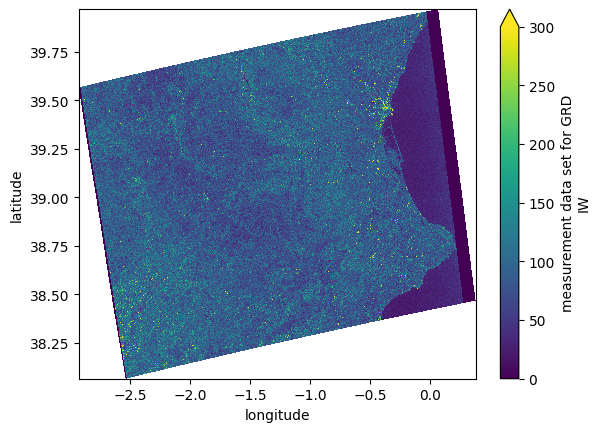

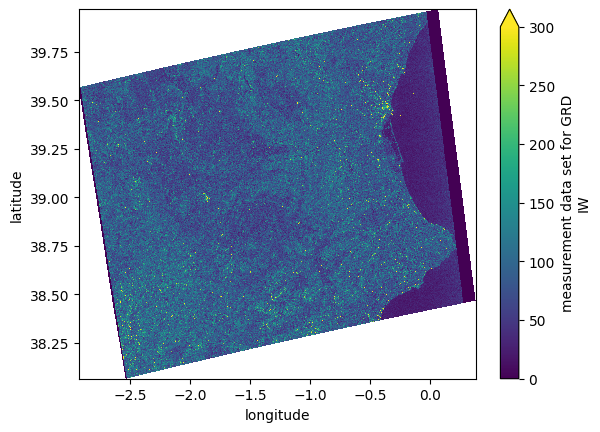

In [163]:
for i in [grd[1], grd[2], grd[5]]:
    #i.plot(vmax=300)
    i.plot(x="longitude", y="latitude", vmax=300)
    plt.show()

In [164]:
# Create calibration list 
i = 0
calibration = []
while i < DATASET_NUMBER:
    calibration.append(datatrees[i][datatrees[i].groups[CALIBRATION_VH_GROUP_ID]].to_dataset())
    i = i + 1

In [165]:
# Calibrate intensity for each product
i = 0
intensity = []
while i < DATASET_NUMBER:
    intensity.append(xarray_sentinel.calibrate_intensity(
        grd[i], 
        calibration[i].beta_nought, 
        as_db=True))
    i = i + 1


/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [188]:
# Calibrate amplitude for each product
i = 0
amplitude = []
while i < DATASET_NUMBER:
    amplitude.append(xarray_sentinel.calibrate_amplitude(
        grd[i], 
        calibration[i].beta_nought))
    i = i + 1

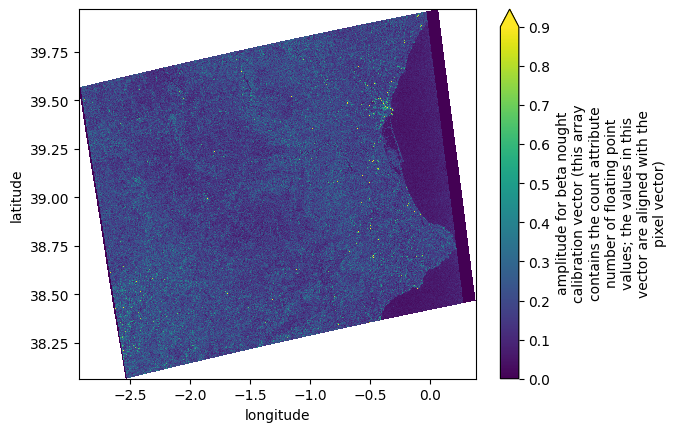

In [193]:
amplitude[2].plot(x="longitude", y="latitude", vmax=0.9)
plt.show()

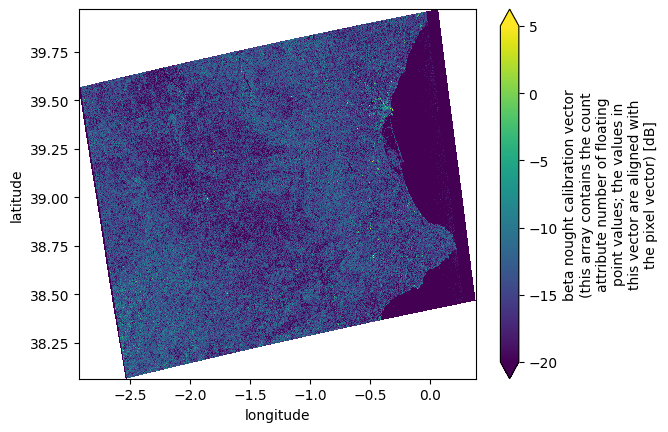

In [191]:
intensity[2].plot(x="longitude", y="latitude", vmin=-20, vmax=5)
plt.show()

In [176]:
grd[2]

<xarray.DataArray 'grd' (azimuth_time: 834, ground_range: 1304)> Size: 2MB
[1087536 values with dtype=uint16]
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 7kB 2024-10-31T18:02:56.11292...
  * ground_range  (ground_range) float64 10kB 0.0 200.0 ... 2.604e+05 2.606e+05
    line          (azimuth_time) float64 7kB 0.0 20.0 ... 1.664e+04 1.666e+04
    pixel         (ground_range) float64 10kB 0.0 20.0 ... 2.604e+04 2.606e+04
    latitude      (azimuth_time, ground_range) float64 9MB 38.07 38.07 ... 39.97
    longitude     (azimuth_time, ground_range) float64 9MB -2.536 ... 0.06295
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    measurement data set for GRD IW

In [186]:
i = 0
while i < DATASET_NUMBER:
    print(intensity[i].shape)
    i = i + 1
    

(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1303)
